# Project 2020  -  Machine Learning and Computational Statistics
### Katsampalos Ilias

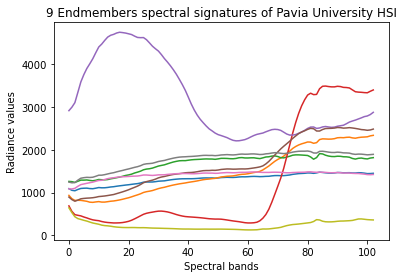

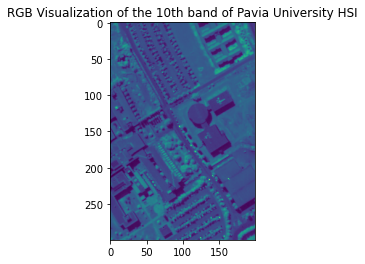

In [3]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt

Pavia = sio.loadmat('PaviaU_cube.mat')
HSI = Pavia['X'] #Pavia HSI : 300x200x103

ends = sio.loadmat('PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends['endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('PaviaU_ground_truth.mat')
labels=ground_truth['y']

fig = plt.figure()
plt.imshow(HSI[:,:,102])
plt.title('RGB Visualization of the 10th band of Pavia University HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

# Part 1 : Spectral Unmixing

We will follow 5 different approaches in order to tackle the issue of spectral unmixing. We will perform

* Least squares: For every pixel, we will try to approach its signature as a linear combination of the pure pixels that we have (endmembers). More precisely, let $X$ be a matrix `(103,9)` where every row is a band of the signature and every column represents one endmember. $Y$ is a vector `(103,1)` where every row is one band of the spectral signature of the pixel that we wish to unmix. Finally, the vector $\theta$ contains the values of the linear combinations. Our model can be expressed in a linear way as: $X\theta + \epsilon= Y$ and our cost function can be expressed as 


$$argmin||X\theta - Y||_2^2$$ 


* Least squares under the non negativity restrictions. Our cost function can be slitghly adjusted as 

$$argmin||X\theta - Y||_2^2 \ \ \textrm{s.t.}  \ \ \theta>0$$ 

 
* Least squares where the values of the linear combinations should sum to 1. Our cost function is modified as

$$argmin||X\theta - Y||_2^2 \ \ \textrm{s.t.}  \ \ \sum \theta = 1$$ 

* Least squares under the non negativity constraint as well as the sum to one constraint. Our cost function is

$$argmin||X\theta - Y||_2^2 \ \ \textrm{s.t.}  \ \ \sum \theta = 1, \ \ \theta>0$$ 

* Lasso: We will impose an $l_1$ penalizeation. The cost function will be modified as:
$$argmin||X\theta - Y||_2^2 + \lambda \sum_{j=1}^{l}|\theta_j|$$

* Adaptive Lasso: Here instead of implementing a traditional Lasso model, we will implement the `Adaptive` Lasso. Following what is proposed in [Semi Supervised Hypespectral Unmixing Via the Weighted Lasso](https://members.noa.gr/tronto/icassp2010.pdf) *Konstantinos E. Themelis, Athanasios A. Rontogiannis and Konstantinos Koutroumbas* we will impose weights on the coefficients, such that not all of them will be penalized by the same amount $\lambda$. As proposed, our weights will have an inverse effect to their corresponding $\theta_{lasso}$. We will use as weight the quantity $w = \frac{1}{|\theta_{ls}|}$ so that small values of $\theta_{ls}$ will penalize more the corresponding $\theta_{lasso}$ and large values of $\theta_{ls}$ will not penalize $\theta_{lasso}$ as much. This will introduce the desired additional sparsity. The optimization of our cost function is adjusted to:
$$argmin||X\theta - Y||_2^2 + \lambda \sum_{j=1}^{l}w_j|\theta_j| \ \ \textrm{where} \ \  w = \frac{1}{|\theta_{ls}|}$$ 

### A few things on the implementation

The technical implementation involves an iterative method for calculating the above quantites. We will iterate over the pixels only once and calculate all the aforementioned quantities. We will end up with 6 matrices, each one with dimension `300,200,9`. For each element of each matrix, which is essential a pixel, we will store the values $\theta_{approach}$ of each approach (which are the values of the linear combination of the endmembers). For the Least Squares approach we will use the analytical solution, where for the constrained least squares we will use `cvxopt`. Finally, for Lasso we use `sklear.linear_model.Lasso` and for `adaptive lasso` we will use `scipy.optimize.minimize`.

### Hypertutning to find the right lambda
In order to avoid optimizing the lambda for each pixel, we can sample some pixels in a stratified way in order to retain the same class distribution, and then calculate the optimal lambdas for those pixels. Then we could extract a statistic for an approximate value of the optimal lambda for each endmember.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
import pandas as pd
#concatenate the labels with each spectral signature
lambda_y = np.column_stack([HSI[labels!=0],labels[labels!=0]])
#sample 20% of the pixels, stratified on the endmembers class
sample,_ = train_test_split(lambda_y,train_size=0.20,stratify=lambda_y[:,-1])

X = endmembers
lambdas = []
#calculate the optimized lambdas for each pixel
for i,pixel in enumerate(sample):
    lasso = LassoCV(cv=3,max_iter=20000,fit_intercept=False,random_state=123,tol=0.001).fit(X,pixel[:-1])
    lambdas.append(lasso.alpha_)
    
#aggregate by each endmember using the median value of lambda
df_lambdas = pd.DataFrame(lambdas)
df_lambdas['label'] = sample[:,-1]

The median optimal values for the regularization parameter $\lambda$ are

In [6]:
optimal_lambdas = df_lambdas.groupby('label').median()
optimal_lambdas

,0
label,
1,4173.865100
2,4525.341548
3,5463.094980
4,3651.454341
5,13321.563314
6,4829.905789
7,4511.069082
8,5506.509256
9,1918.861820


After having a statistic of the regularization parameter $\lambda$ for each label, we will start calculating the unmixing parameters $\theta$

In [7]:
from cvxopt import matrix, solvers
from sklearn.linear_model import LassoCV, Lasso
import pandas as pd
from l1regls import l1regls
from scipy.optimize import minimize

solvers.options['show_progress'] = False

#endmembers are assigned as X
X = endmembers

# create matrices (300,200,9) for each approach
thetas_ls = np.empty((HSI.shape[0],HSI.shape[1],endmembers.shape[1]))
thetas_nn = np.empty((HSI.shape[0],HSI.shape[1],endmembers.shape[1]))
thetas_sum_one = np.empty((HSI.shape[0],HSI.shape[1],endmembers.shape[1]))
thetas_nn_sum_one = np.empty((HSI.shape[0],HSI.shape[1],endmembers.shape[1]))
thetas_lasso = np.empty((HSI.shape[0],HSI.shape[1],endmembers.shape[1]))
thetas_adaptive_lasso = np.empty((HSI.shape[0],HSI.shape[1],endmembers.shape[1]))

#loop through the pixels without flattening the array
for i in range(HSI.shape[0]):
    for j in range(HSI.shape[1]):
        #if the label == 0 proceed to the next pixel without processing
        label = labels[i][j]
        if label == 0:
            continue
        #Y is the spectral signature of each pixel
        Y = HSI[i][j]
        
        #Least Squares
        thetas = np.linalg.inv(X.T@X) @ X.T @ Y
        thetas_ls[i][j] = thetas
        
        #Define our matrices for cvxopt
        P = matrix(np.dot(X.T,X))
        q = matrix(-(X.T @ Y))
        b = matrix(1.0)
        A = matrix(np.ones(X.shape[1]), (1,X.shape[1]))
        G = matrix(-np.identity(X.shape[1]))
        h = matrix(np.zeros(X.shape[1]))
        
        #positive thetas
        thetas_nn[i][j] = np.array(solvers.qp(P=P, q=q, G=G, h=h, A=None, b=None)['x']).flatten()
        #sum to one
        thetas_sum_one[i][j] = np.array(solvers.qp(P=P, q=q, G=None, h=None, A=A, b=b)['x']).flatten()
        #positive thetas sum to one
        thetas_nn_sum_one[i][j] = np.array(solvers.qp(P=P, q=q, G=G, h=h, A=A, b=b)['x']).flatten()
        
        #retrieve the optimal lambda for each class
        lambda_ = optimal_lambdas.iloc[label-1][0]
        #Lasso
        lasso = Lasso(fit_intercept=False,alpha=lambda_,max_iter=5000, tol=0.001).fit(X,Y)
        thetas_lasso[i][j] = lasso.coef_
        
        #Adaptive Lasso
        # our weights are the inverse of the least squares coefficients calculated before
        weights = 1/thetas_ls[i][j]
        #initialize for thetas
        theta_0 = np.zeros(X.shape[1])
        #regularization parameter
        
        #define the cost function of the lasso
        lasso = lambda theta: (X@theta - Y).T @ (X@theta - Y) + lambda_ * np.sum(np.abs(weights * theta))
        #minimize the cost function and assign to the respective pixel
        thetas_adaptive_lasso_ = minimize(lasso, theta_0,method='L-BFGS-B' ,options={'disp': False},tol=0.0005)
        thetas_adaptive_lasso[i][j] = thetas_adaptive_lasso_['x']

In order to understand better the performance of the models, as well as recognize endmembers where the model does not perform well, we can calculate the reconstruction per endmember.

In [8]:
#define a function calculating the reconstruction error
def reconstruction_error(X, thetas, Y):
    squared_error = np.sum((thetas @ X.T - Y)**2, axis=1) 
    return squared_error

#keep the pixels which are labeled as non zero for calculating the reconstruction error
Y = HSI[np.where(labels!=0)]
#for each approach, calculate the recostruction error
reconstruction_error_ls = reconstruction_error(X, thetas_ls[np.where(labels!=0)], Y)
reconstruction_error_nn = reconstruction_error(X, thetas_nn[np.where(labels!=0)], Y)
reconstruction_error_sum_one = reconstruction_error(X, thetas_sum_one[np.where(labels!=0)], Y)
reconstruction_error_nn_sum_one = reconstruction_error(X, thetas_nn_sum_one[np.where(labels!=0)], Y)
reconstruction_error_lasso = reconstruction_error(X, thetas_lasso[np.where(labels!=0)], Y)
reconstruction_error_adaptive_lasso = reconstruction_error(X, thetas_adaptive_lasso[np.where(labels!=0)], Y)

#create a dataframe with the error of each pixel. we also create a column with the label of each pixel
error = pd.DataFrame({
    'least_squares' : reconstruction_error_ls
    ,'least_squares_sum_one' : reconstruction_error_sum_one
    ,'least_squares_non_negative' : reconstruction_error_nn
    ,'least_squares_non_negative_sum_one': reconstruction_error_nn_sum_one
    ,'lasso' : reconstruction_error_lasso
    ,'adaptive_lasso' : reconstruction_error_adaptive_lasso
    ,'label' : labels[np.where(labels!=0)]
})

#create a dataframe with with the names of the labels
label_descriptions = pd.DataFrame({
    'label' : [1,2,3,4,5,6,7,8,9]
    ,'description' : ['water', 'trees', 'asphalt', 'bricks', 'bitumen', 'tiles', 'shadows', 'meadows', 'bare soil']
})

#join with the names of the labels and calculate the mean recostruction error per label
error = pd.merge(error, label_descriptions, left_on='label' ,right_on='label')
agg = error.groupby('description').mean()
agg

,least_squares,least_squares_sum_one,least_squares_non_negative,least_squares_non_negative_sum_one,lasso,adaptive_lasso,label
description,,,,,,,
asphalt,107204.927687,148591.202341,3.329407e+05,8.284820e+05,270775.249123,189026.123736,3
bare soil,101228.688542,136899.178750,2.762530e+05,5.320564e+05,197367.998468,159217.146525,9
bitumen,144699.181060,196057.403321,1.746750e+06,3.841625e+07,711016.256811,286016.665558,5
bricks,186160.483631,235821.209057,9.701289e+05,8.381218e+06,558548.795485,371004.029446,4
meadows,110308.230892,147866.556471,2.934133e+05,6.373767e+05,270662.133266,405992.064958,8
shadows,101524.731381,139894.013324,2.238552e+05,2.670043e+05,249816.974355,200874.194979,7
tiles,130395.881241,173187.755729,9.415832e+05,7.093903e+06,411221.372562,216105.200907,6
trees,111636.312884,149745.531851,4.890742e+05,7.099852e+05,281850.637298,175576.062601,2
water,111018.554601,154204.800248,1.996002e+05,2.645509e+05,254164.944159,173249.266012,1


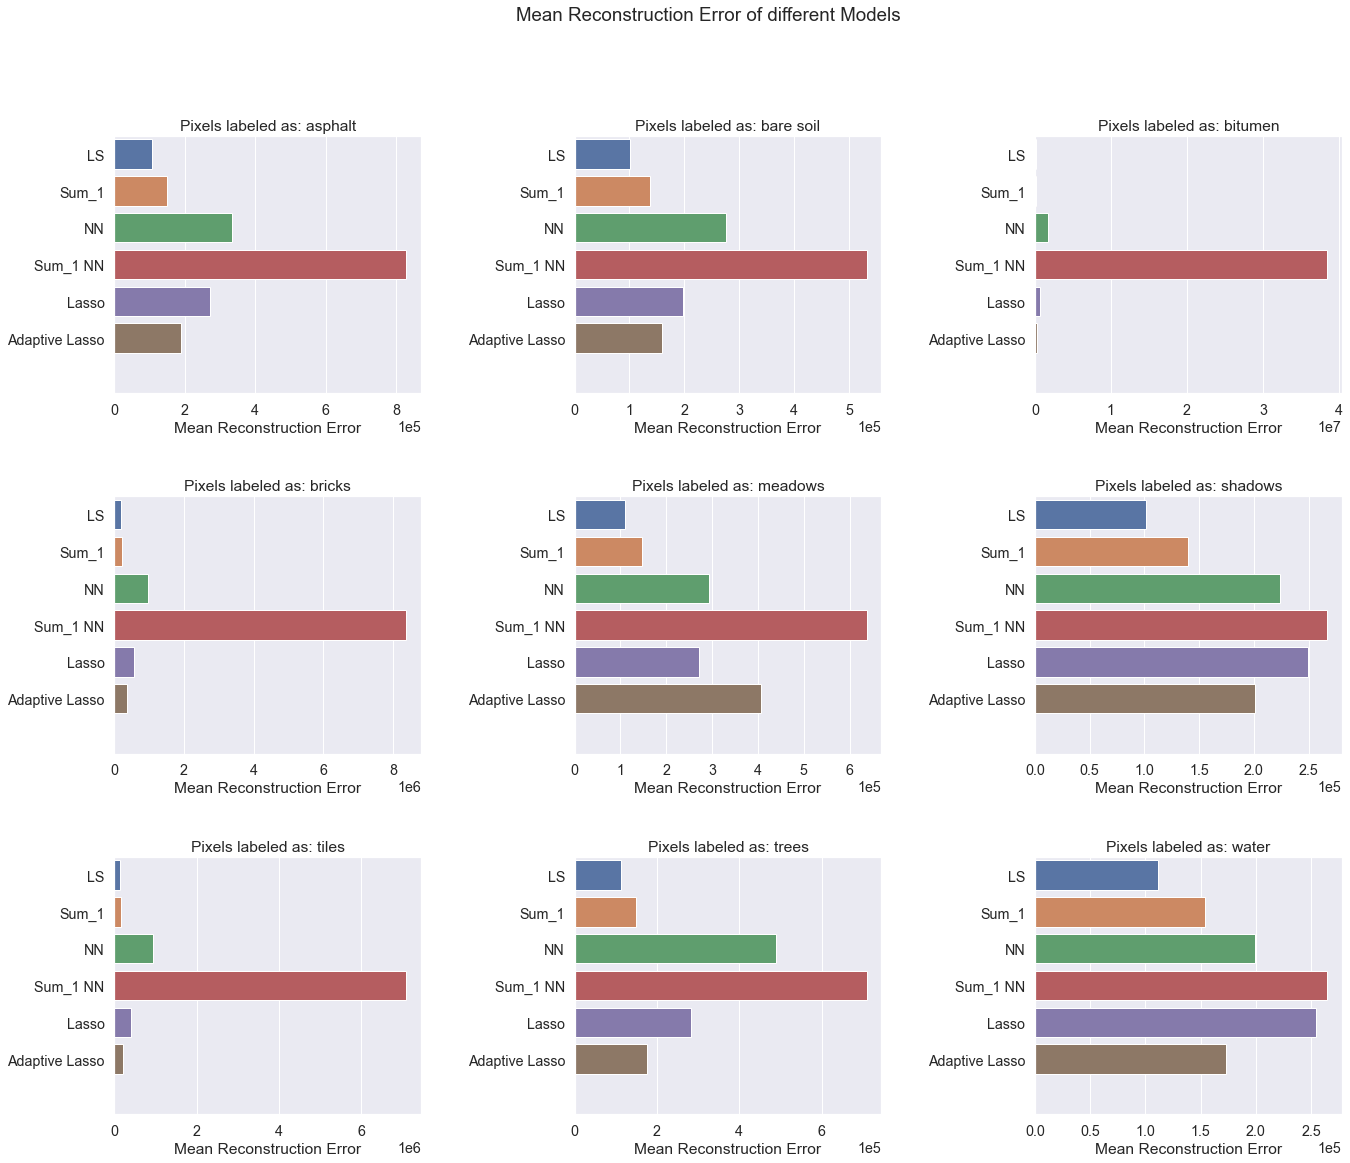

In [21]:
#plot the reconstruction error per label
import seaborn as sns
sns.set(palette='deep', color_codes=True, font_scale=1.3)
fig, axs = plt.subplots(3,3, figsize = (22,18))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4, wspace=0.5)
fig.suptitle('Mean Reconstruction Error of different Models')

for i in range(len(agg.T.columns)):
    sns.barplot(agg.T.iloc[:,i],agg.T.index, ax=axs[i])
    axs[i].set(yticklabels=['LS', 'Sum_1', 'NN', 'Sum_1 NN', 'Lasso', 'Adaptive Lasso'])
    axs[i].title.set_text('Pixels labeled as: ' + agg.T.columns[i])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('Mean Reconstruction Error')
    axs[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

Observations:
* The reconstruction error of the least squares with the non negativity and and "sum to one" constraints is the highest for all classes, which is natural due to the constrained optimization
* The uncostrained least squares achieves the lowest recostruction errors for all classes
* The Lasso recostruction error has wider deviations. Most of the times it performs slightly worse than the uncostrained least squares
* The least squares with the non negativity and and "sum to one" constraints performs really poorly under the bitumen, tiles and blocking bricks in terms of recostruction errors.

Later while plotting the ambundance maps, we will be able to correlate the recostruction error plots with the quality of the ambundance maps.

In [18]:
def ambundance_map(label):
    fig, axs = plt.subplots(2,4, figsize=(18,10))
    plt.subplots_adjust(wspace=0.3)
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    axs[0][0].imshow((labels == label).astype(int), cmap=cmap)
    axs[0][0].grid(False)
    axs[0][0].title.set_text('Ground Truth')

    axs[0][1].imshow(thetas_ls[:,:,label-1], cmap=cmap)
    axs[0][1].grid(False)
    axs[0][1].title.set_text('1. Least Squares')
    
    axs[0][2].imshow(thetas_sum_one[:,:,label-1], cmap=cmap)
    axs[0][2].grid(False)
    axs[0][2].title.set_text('2. LS $\sum θ=1$')

    axs[0][3].imshow(thetas_nn[:,:,label-1], cmap=cmap)
    axs[0][3].grid(False)
    axs[0][3].title.set_text('3. LS $θ>0$')
    
    axs[1][0].imshow(thetas_nn_sum_one[:,:,label-1], cmap=cmap)
    axs[1][0].grid(False)
    axs[1][0].title.set_text('4. LS $θ>0$ and $\sum θ=1$')
    
    axs[1][1].imshow(thetas_lasso[:,:,label-1], cmap=cmap)
    axs[1][1].grid(False)
    axs[1][1].title.set_text('5. Lasso')
    
    axs[1][2].imshow(thetas_adaptive_lasso[:,:,label-1], cmap=cmap)
    axs[1][2].grid(False)
    axs[1][2].title.set_text('6. Adaptive Lasso')
    
    axs[1][3].axis('off')
    plt.show()

## 1.Water

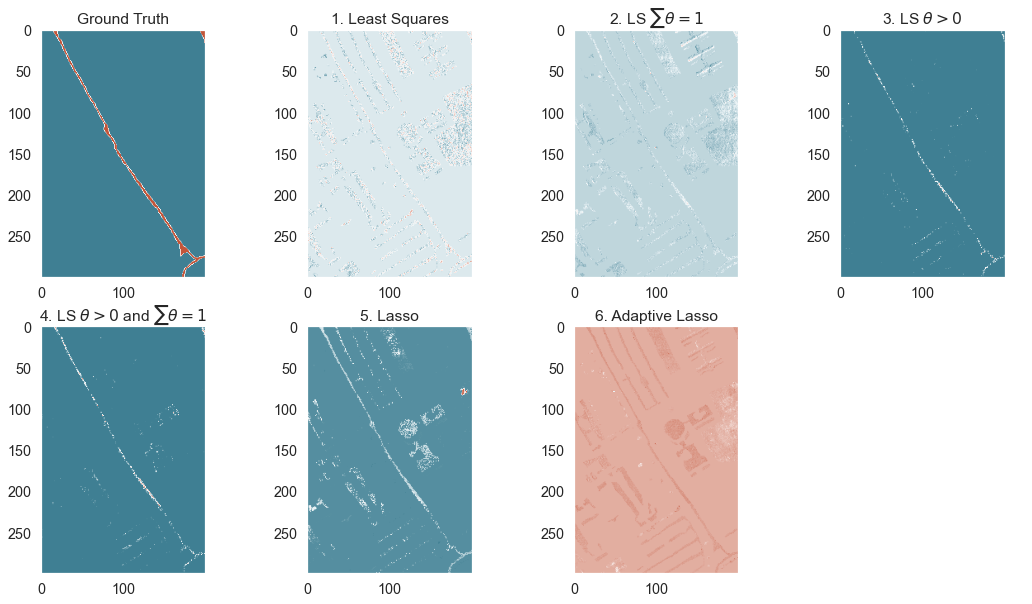

In [36]:
ambundance_map(1)

Regarding the `water` ambundance map, we can clearly see that the models `3` and `4` perform really well. The model `1` and `2` do not perform so well. The model `5` (Lasso) is able to identify the water trail but with lots of noise around it. Model `6` has imposed some additional sparsity but it contains noise as well

## 2.Trees

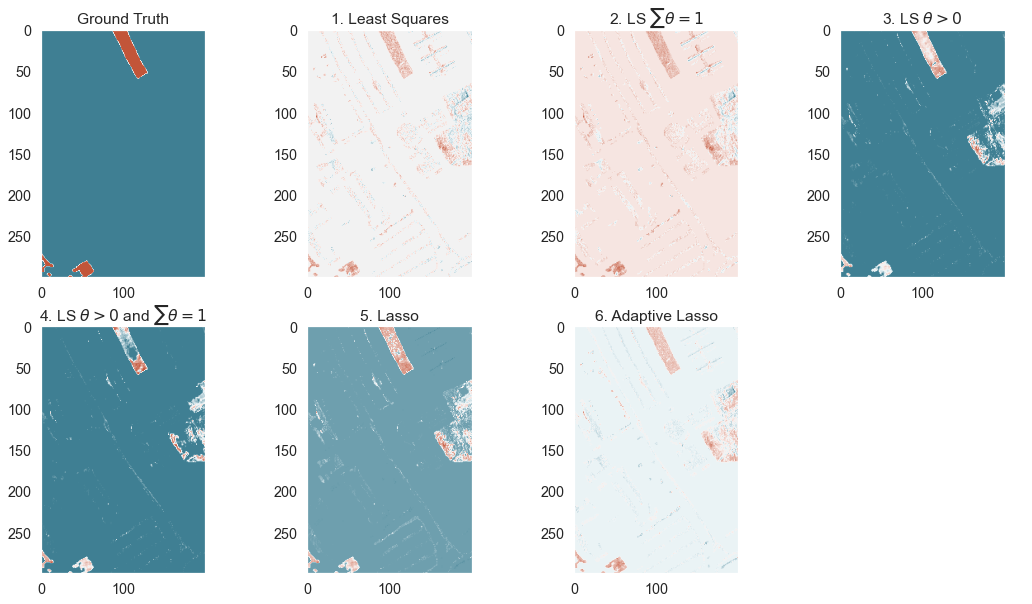

In [37]:
ambundance_map(2)

* Again the models `3` and `4` are able to identify Trees with a lot of noise coming from Tiles
* Models `1` and `2` still underperform. They identify the trees with lots of additional noise
* Model `5` was able to supress much of the noise but still suffers from noise coming from Tiles
* The same is observed for model `6`, which even if it imposed additional sparsity, there is additional noise coming from tiles

## 3.Asphalt

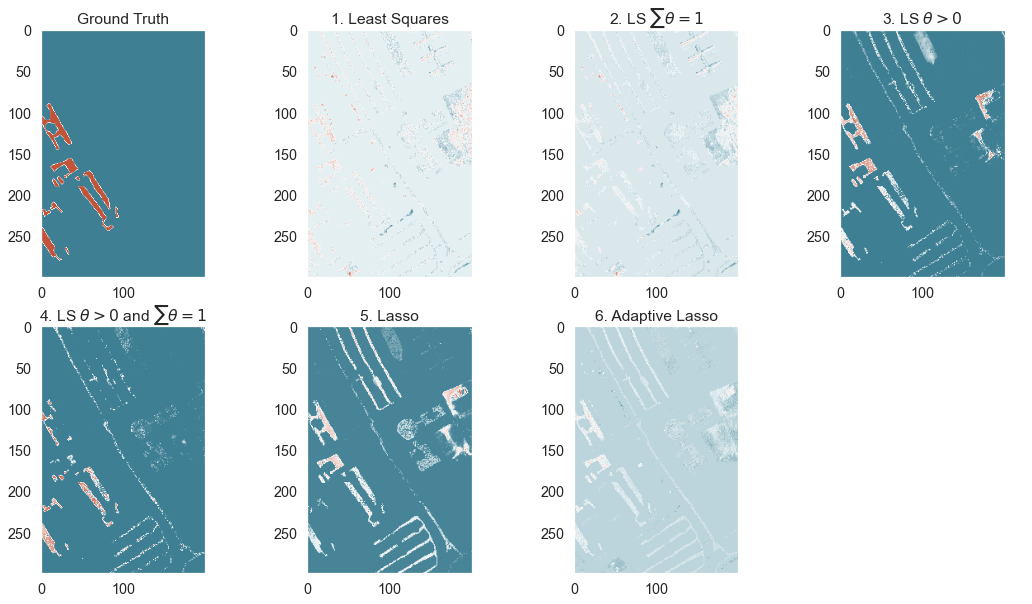

In [38]:
ambundance_map(3)

* The models with the greatest discriminatory power are `3` and `4` with lots of additional noise though
* Model `5` contains lots of noise coming from other endmembers
* Model `6` has managed to impose sparsity and unmix a considerable amount of asphalt

## 4.Self Blocking Bricks

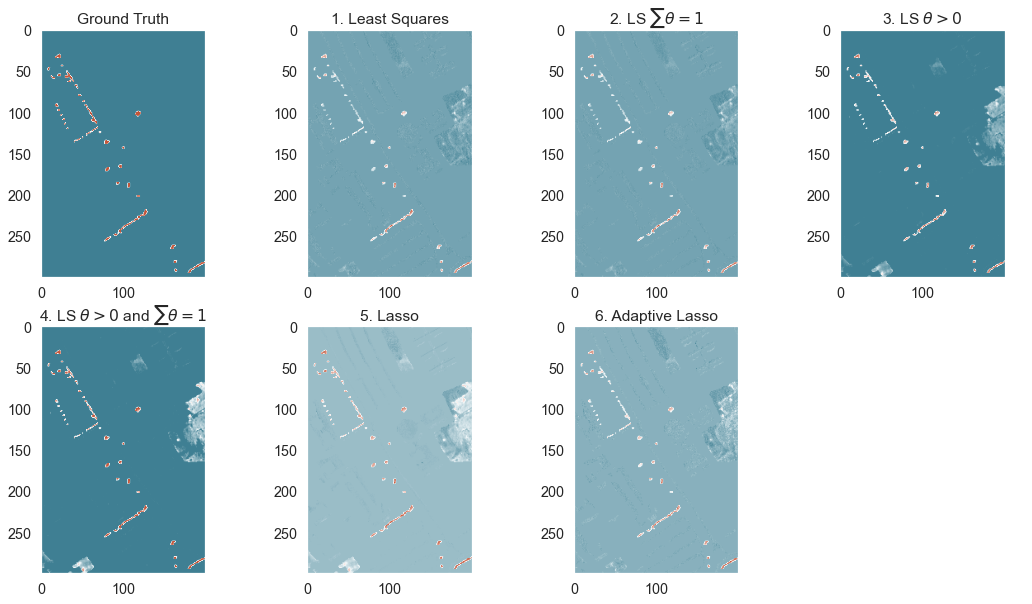

In [39]:
ambundance_map(4)

Here all models perform well

## 5.Bitumen

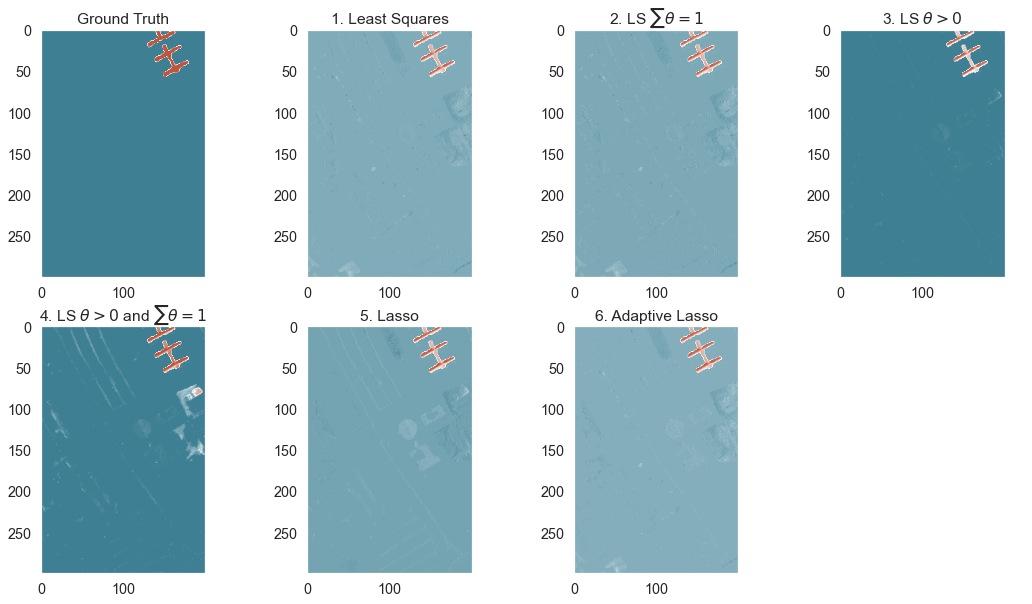

In [40]:
ambundance_map(5)

All models are able to identify Bitumen. There some additional of noise in model `4`. Both lasso and adaptive lasso has managed to supress it.

## 6.Tiles

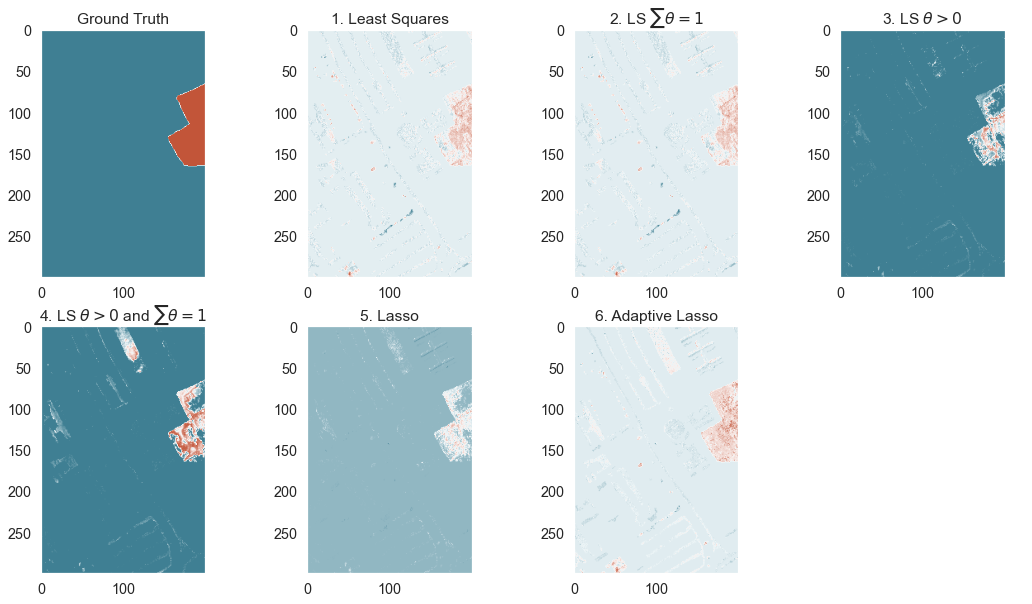

In [41]:
ambundance_map(6)

* Tiles are identified almost correctly by models `3` and `4`. Model `4` containes some additional noise coming from trees.
* Models `1` and `2` are noisy
* Model `5` has a clearer outline of the shape of the tiles
* Model `6` imposed greater sparsity and unmixed tiles more vividly

## 7.Shadows

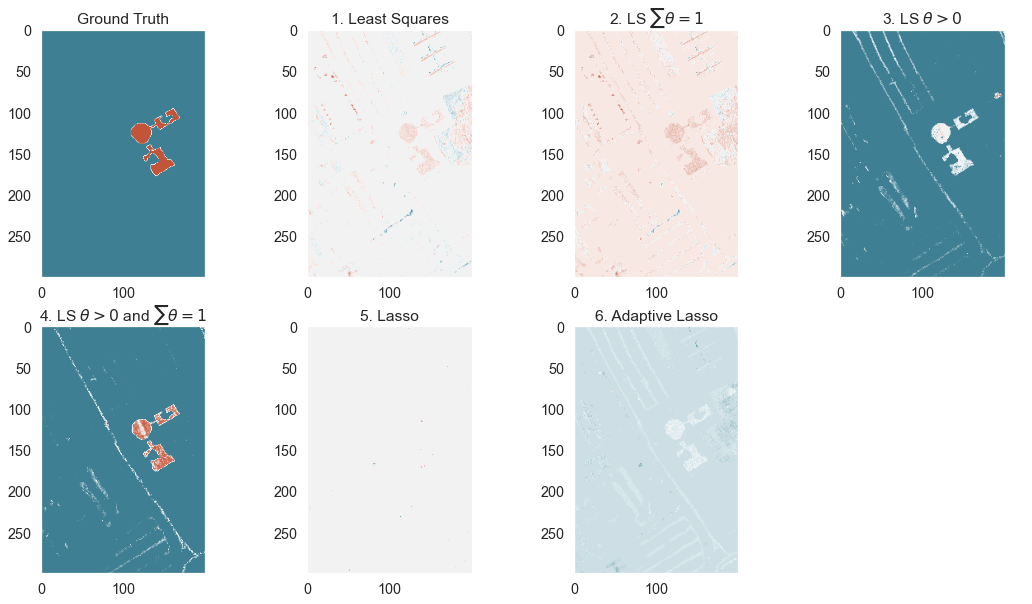

In [42]:
ambundance_map(7)

* Here only the model `4` performs well
* Model `5` was not able to capture shadows at all
* Model `2` as well as model `6` were able to unmix shadows but with much additional noise

## 8.Meadows

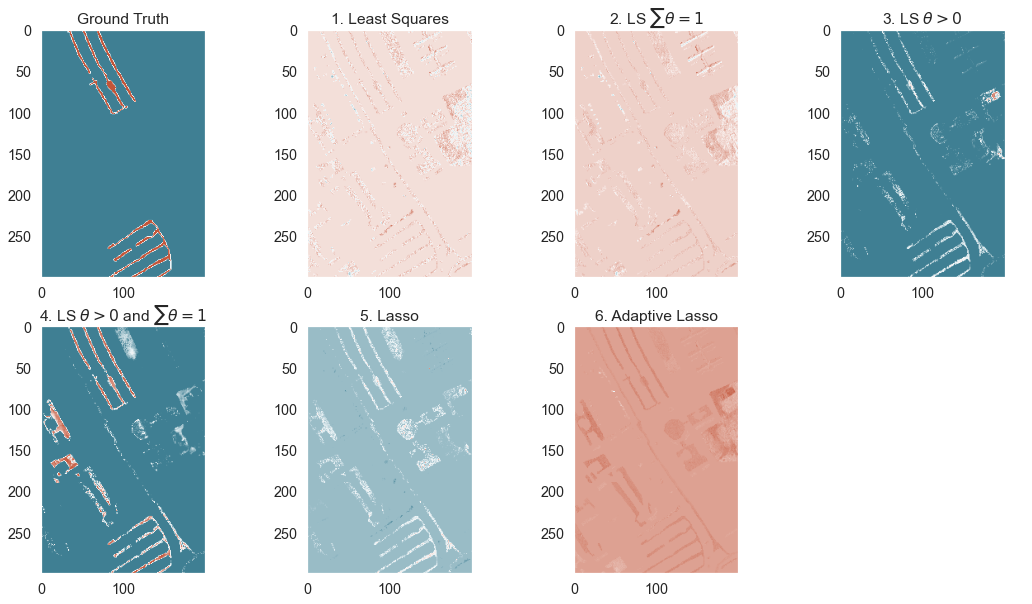

In [43]:
ambundance_map(8)

Model `4` together with `5` are able to identify meadows. There is additional noise coming from asphalt

## 9.Bare Soil

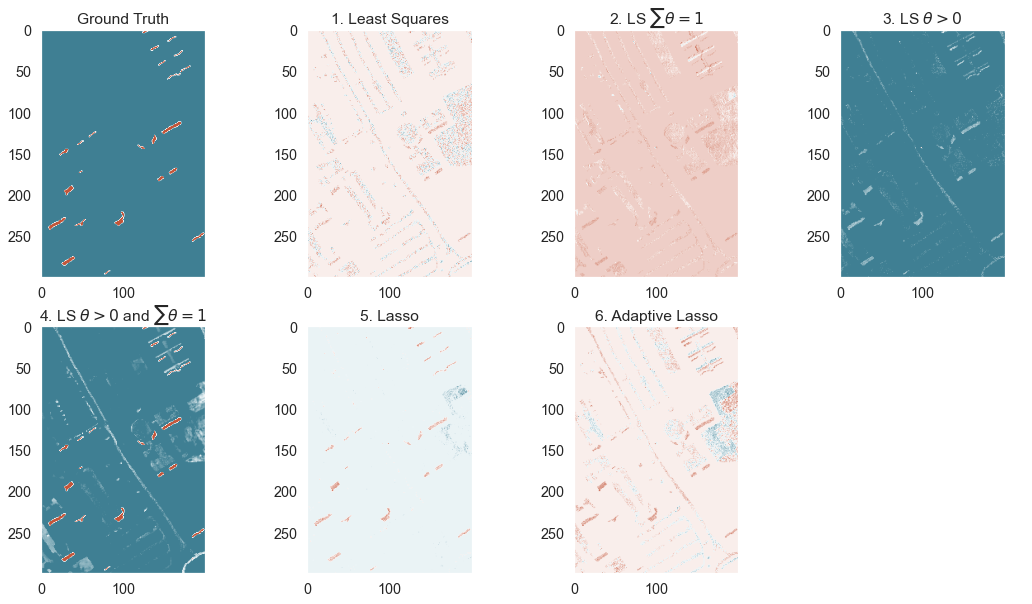

In [44]:
ambundance_map(9)

Here models `4` and `5` are able to identify bare soil

### Spectral Unmixing - Observations
* Due to the physical limitations of the task, the least squares model with $\sum \theta=1, \ \ \theta>0$ outperforms the other 5 models
* The unconstrained least squares model does not perform well. Since there is no constraint on the parameters, the solution that minimizes the criterion introduces a lot of noise
* We observe a negative relationship between the discrimination power in the ambundance maps and the reconstruction error. Models with really high recostruction error, such as the least squares model with $\sum \theta=1, \ \ \theta>0$ display high discriminatory power even though its reconstruction error is consistently the highest. 
* Lasso as well as the Adaptive Lasso which uses the inverese of the parameters of the least squares achieved the required sparsity. Further optimization for the ideal values of $\lambda$ could result in equally good results with the fully constrained least squares model

# Part 2: Classification

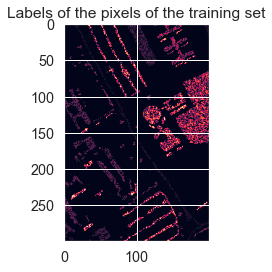

In [49]:
# Trainining set for classification 
Pavia_labels = sio.loadmat('classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

### Define our datasets

In [51]:
X_train = HSI[np.where(Training_Set>0)]
y_train = Training_Set[np.where(Training_Set>0)]
X_test = HSI[np.where(Test_Set>0)]
y_test = Test_Set[np.where(Test_Set>0)]

### Check for correlations
We will plot the correlation map for each class in order to get an idea of how well the classifiers will perform

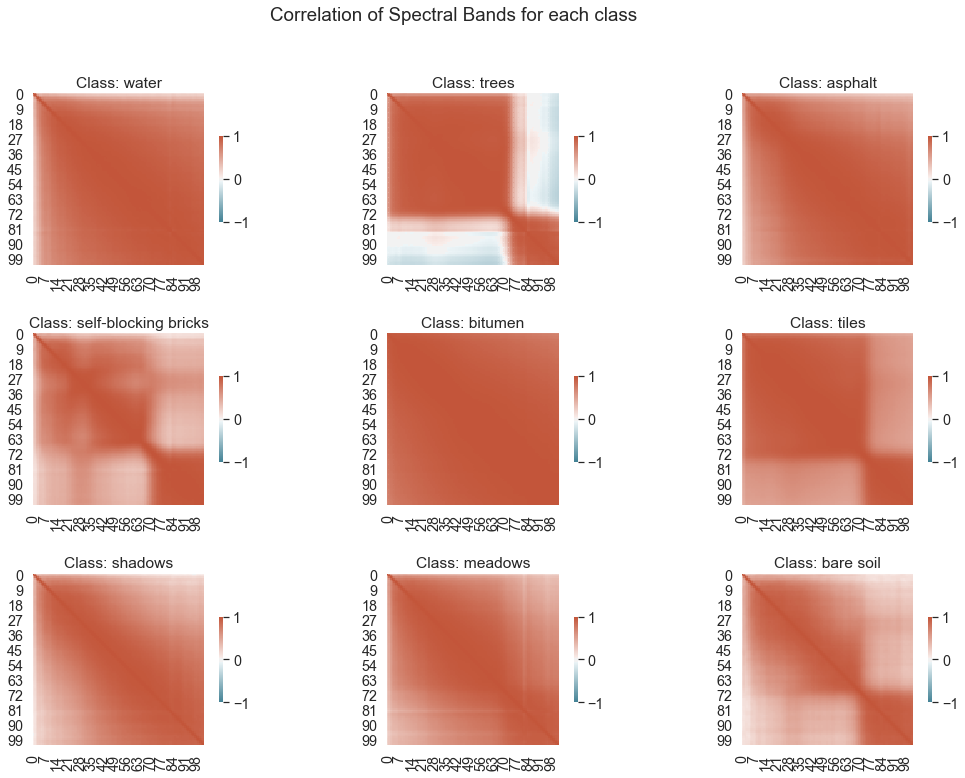

In [122]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
fig, axs = plt.subplots(3,3, figsize=(18,12))
axs = axs.ravel()
plt.subplots_adjust(hspace=0.4)
fig.suptitle('Correlation of Spectral Bands for each class')

for i in range(9):
    x_class = X_train[y_train==i+1]
    corr = np.corrcoef(x_class.T)
    mask = np.triu(np.ones_like(corr))
    sns.heatmap(corr, vmin=-1, vmax=1, cmap=cmap, center=0, square=True, cbar_kws={"shrink": .5}, ax=axs[i])
    axs[i].title.set_text('Class: ' + label_descriptions.iloc[i,1])

For every class, we observe very high correlations between the bands of each signature. This might harm models that assume diagonal covariance matrices such as the Naive Bayes and the Minimum Euclidean Distance Classifier.

### Define function for cross validation

In [123]:
def cross_validation(X_train, y_train, folds, classifier):
    '''
    Performs k fold cross validation and returns statistics.
    
    Parameters:
        X_train (array): the training dataset
        
        y_train (array): the labels of the training dataset
        
        folds (int): the number of folds of the cross validation
        
        classifier: initialized object of a classifier. 
                    It needs to contain a fit and predict method
    
    Returns:
        mean_validation_error (float): the mean validation error after the k folds
        
        standard_deviation (float): the standard deviation of the mean validation error
        
        validation_errors (array): the validation error for each fold
    '''
    
    #set a random seed
    np.random.seed(123)
    #create a dataframe for easier manipulation
    df = pd.DataFrame(X_train)
    df['y'] = y_train
    #create a column with random integers, shuffling the data
    df['shuffle'] = np.random.randint(0,1000,len(X_train))
    #qcut() function from pandas, partition the dataset to k equal subsets, label them as 1 to folds
    df['partition'] = pd.qcut(df.shuffle, folds, labels=range(1,folds+1))
    
    validation_errors = []
    for i in range(1, folds+1):
        #for each fold keep the subset that is not equal to the fold as train
        x_train = df[df.partition != i].iloc[:,0:103]
        y_train = df[df.partition != i].y
        #keep the validation that is equal to the fold as validation
        x_validation = df[df.partition == i].iloc[:,0:103]
        y_validation = df[df.partition == i].y
        
        #fit on the train subset
        classifier.fit(x_train, y_train)
        #predict the x_validation subset
        predictions = classifier.predict(x_validation)
        #calculate the classification error
        error = np.sum(y_validation != predictions) / len(y_validation)
        validation_errors.append(error)
    res = {
        'mean_validation_error' : np.mean(validation_errors)
        ,'standard_deviation_error' : np.std(validation_errors)
        ,'validation_errors' : validation_errors
    }
    return res

## A)i) Cross Validation
### Naive Bayes

In [124]:
from sklearn.naive_bayes import GaussianNB
naive_bays_results = cross_validation(X_train, y_train, 10, GaussianNB())
naive_bays_results

{'mean_validation_error': 0.34046842342402994,
 'standard_deviation_error': 0.01353816475595082,
 'validation_errors': [0.35030864197530864,
  0.360062893081761,
  0.31627906976744186,
  0.340625,
  0.325508607198748,
  0.33900928792569657,
  0.3474178403755869,
  0.33853354134165364,
  0.328125,
  0.358814352574103]}

### Minimum Euclidean Distance 
Here we will define a custom classifier in order to be able to pass it through our cross validation function. We will need to imlpement the methods `fit` and `predict` in accordance with the sklearn classifiers

In [125]:
class MinimumEuclideanDistanceClassifier:
    
    def __init__(self, classes):
        self.classes = classes
        self.means = None
    
    def fit(self, X, y):
        '''
        Calculates the means of each class. It creates a dataframe object,
        attaches the labels as a column in order to aggragate the features on them
        
        Parameters:
            X (array): array of features 
            Y (array): labels of observations
            
        Returns:
            MinimumEuclideanDistanceClassifier
        '''
        df = pd.DataFrame(X)
        df['y'] = y
        means = df.groupby('y').mean()
        self.means = np.array(means)
        return self
    
    def predict(self, X):
        '''
        Using broadcasting for avoiding loops, assigns each observation to the closest class
        For more info on broadcasting please check 
        https://numpy.org/doc/stable/user/basics.broadcasting.html
        
        Parameters:
            X (array): array of observations to predict
        
        Returns:
            predictions (array): Vector of predictions
        '''
        X = np.array(X)
        distances = np.sum((X[:,np.newaxis,:] - self.means)**2, axis=2)
        predictions = np.argmin(distances, axis=1) + 1
        return predictions

In [56]:
ed_res = cross_validation(X_train, y_train, 10, MinimumEuclideanDistanceClassifier(classes=9))
ed_res

{'mean_validation_error': 0.43430108872788775,
 'standard_deviation_error': 0.014410462816171359,
 'validation_errors': [0.4382716049382716,
  0.4418238993710692,
  0.4232558139534884,
  0.4390625,
  0.41158059467918623,
  0.43962848297213625,
  0.4647887323943662,
  0.4165366614664587,
  0.428125,
  0.43993759750390016]}

### KNN

In [57]:
#perform cross validation in order to tune the K hyperparameter
from sklearn.neighbors import KNeighborsClassifier

neighbors = {}
for k in range(3,10):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_res = cross_validation(X_train, y_train, 10, knn)
    neighbors[k] = knn_res['mean_validation_error']
neighbors

{3: 0.12002496200015418,
 4: 0.12626923572513182,
 5: 0.12064223312625721,
 6: 0.12345449826447567,
 7: 0.11986559931219812,
 8: 0.12454925581414111,
 9: 0.12048428669037144}

In [58]:
# validation only with 7 nearest neighbors
knn_res = cross_validation(X_train, y_train, 10, KNeighborsClassifier(n_neighbors=7))
knn_res

{'mean_validation_error': 0.11986559931219812,
 'standard_deviation_error': 0.01251810434664451,
 'validation_errors': [0.13580246913580246,
  0.13836477987421383,
  0.12713178294573643,
  0.1109375,
  0.11424100156494522,
  0.10990712074303406,
  0.09702660406885759,
  0.1310452418096724,
  0.121875,
  0.11232449297971919]}

## Quadratic Discriminant Analysis

In [59]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda_res = cross_validation(X_train, y_train, 10, qda)
qda_res

{'mean_validation_error': 0.11784649834804976,
 'standard_deviation_error': 0.015233180432647158,
 'validation_errors': [0.12191358024691358,
  0.12264150943396226,
  0.13643410852713178,
  0.1046875,
  0.11267605633802817,
  0.10061919504643962,
  0.1111111111111111,
  0.1419656786271451,
  0.1328125,
  0.093603744149766]}

## Validation Errors

In [128]:
#create a datafrae with all the validation error
errors = pd.DataFrame({
    'fold' : range(1,11)
    ,'naive_bayes': naive_bays_results['validation_errors']
    ,'min_eucl_dist' : ed_res['validation_errors']
    ,'knn' : knn_res['validation_errors']
    ,'bayes_classifier': qda_res['validation_errors']
})
errors

,fold,naive_bayes,min_eucl_dist,knn,bayes_classifier
0,1,0.350309,0.438272,0.135802,0.121914
1,2,0.360063,0.441824,0.138365,0.122642
2,3,0.316279,0.423256,0.127132,0.136434
3,4,0.340625,0.439063,0.110937,0.104688
4,5,0.325509,0.411581,0.114241,0.112676
5,6,0.339009,0.439628,0.109907,0.100619
6,7,0.347418,0.464789,0.097027,0.111111
7,8,0.338534,0.416537,0.131045,0.141966
8,9,0.328125,0.428125,0.121875,0.132812
9,10,0.358814,0.439938,0.112324,0.093604


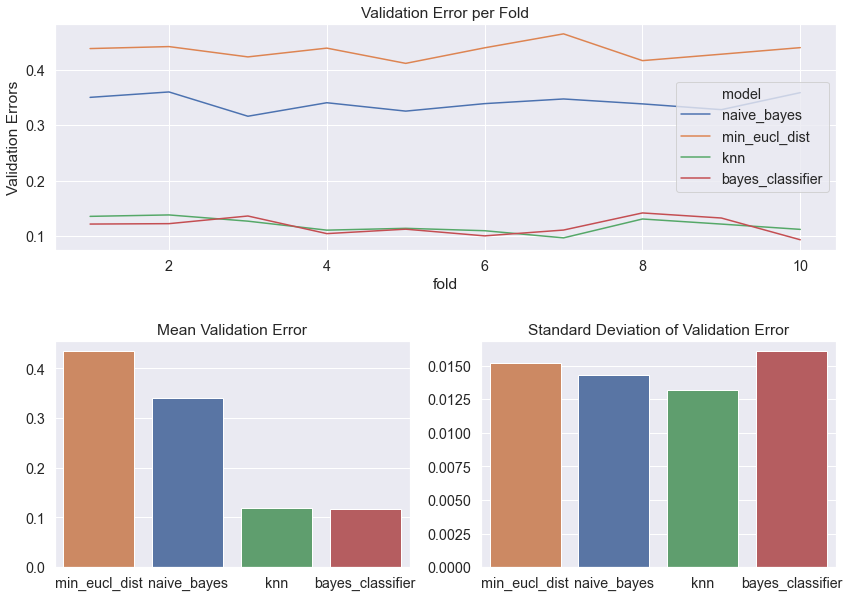

In [129]:
import seaborn as sns

sns.set(palette='deep', color_codes=True, font_scale=1.3)
errors = pd.melt(errors, id_vars='fold', var_name='model', value_name='validation_error')

#plot the validation errors over the folds
fig = plt.figure(figsize=(14,10))
gs = fig.add_gridspec(2, 2)
plt.subplots_adjust(hspace=0.4)

ax1 = fig.add_subplot(gs[0, :])
ax1.title.set_text('Validation Error per Fold')
sns.lineplot(errors.fold, errors.validation_error, hue=errors.model)
ax1.set_ylabel('Validation Errors')

#aggregate the erros per model
agg = errors.groupby(['model']).agg(
    mean_validation_error = ('validation_error', np.mean)
    ,standard_deviation_of_error = ('validation_error', np.std)
)
agg.sort_values('mean_validation_error', inplace=True, ascending=False)

palette = [sns.color_palette()[1], sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[3]]
ax2 = fig.add_subplot(gs[1 , 0])
sns.barplot(agg.index, agg.mean_validation_error, palette=palette)
ax2.title.set_text('Mean Validation Error')
ax2.set_ylabel('')
ax2.set_xlabel('')

ax3 = fig.add_subplot(gs[1 , 1])
sns.barplot(agg.index, agg.standard_deviation_of_error, palette=palette)
ax3.title.set_text('Standard Deviation of Validation Error')
ax3.set_ylabel('')
ax3.set_xlabel('')
plt.show()

A few Observations:
* Cross validation seems to be working properly, since there are no big fluctuations over the 10 folds.
* Another indicator of the stability of the scores are the standard deviations of the validation errors, which are quite low
* Minimum Euclidean Distance and Naive Bayes do not achieve low error rates. This is natural, since as we visualized in the beginning, there are strong correlations between the 103 bands of the signature of each pixel and these models assume diagonal covariances
* On the other hand, the non parametric KNN as well as the "fully" parametric Bayes Classifier, which takes into consideration the Covariance Matrices of each endmember class, achieve the lowest mean validation error

## A)ii) Training on the whole Train Set and predictions on the Test Set

In [62]:
gnb = GaussianNB().fit(X_train, y_train)
med = MinimumEuclideanDistanceClassifier(9).fit(X_train, y_train)
knnc = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)
bc = QuadraticDiscriminantAnalysis(store_covariance=True).fit(X_train, y_train)

In [63]:
gnb_predictions = gnb.predict(X_test)
med_predictions = med.predict(X_test)
knnc_predictions = knnc.predict(X_test)
bc_predictions = bc.predict(X_test)

### Naive Bayes

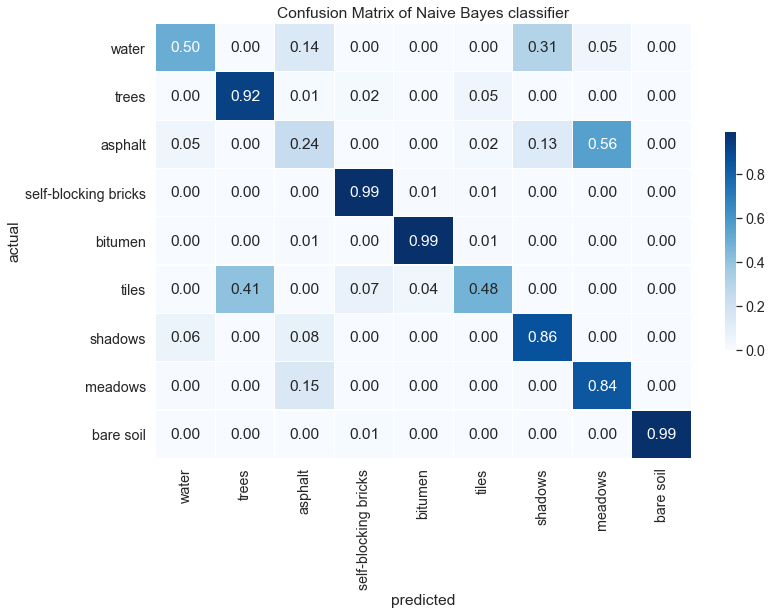

accuracy: 0.660118490801372
f1 score: 0.6387252125125221


In [134]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
def plot_confusion_matrix(confusion_matrix, classifier):
    fig, axs = plt.subplots(figsize=(12,8))
    axs =sns.heatmap(
        confusion_matrix
        ,annot=True
        ,cmap='Blues'
        ,linewidths=0.1
        ,xticklabels= label_descriptions.description
        ,yticklabels = label_descriptions.description
        ,ax=axs
        ,fmt = '.2f'
        ,cbar_kws = {'shrink':0.5}
    )
    
    axs.set_xlabel('predicted')
    axs.set_ylabel('actual')
    axs.title.set_text('Confusion Matrix of ' + classifier + ' classifier')
    plt.show()

gnb_conf = confusion_matrix(y_test, gnb_predictions, normalize='true')
plot_confusion_matrix(gnb_conf, 'Naive Bayes')
print('accuracy:', accuracy_score(y_test, gnb_predictions))
print('f1 score:', f1_score(y_test, gnb_predictions, average='weighted'))

The `accuracy` as well as the `f1 score` are not ideal for the Naive Bayes classifier. More particularly it is not able to capture the endmemers of:
* Water, which it confuses with asphalt(14% classification error out of Water) and shadows (31% classification error)
* Ashpalt, which it confuses with Shadows (13% Class. Err.) or Meadows (56% Class. Err.)
* Tiles, which it confuses mainly with trees(41% Class. Err.)

As an example, we will plot below the means of `Water` and `Shadow`, which are used for the Naive Bayes model. On top, we will plot all the datapoints classified `correctly` as `water`, as well as the datapoints `missclassified` as `shadows`, even though they were `water`. We can observe that the spectral signatures of the missclassified datapoints is much closer to the mean values of the shadows.

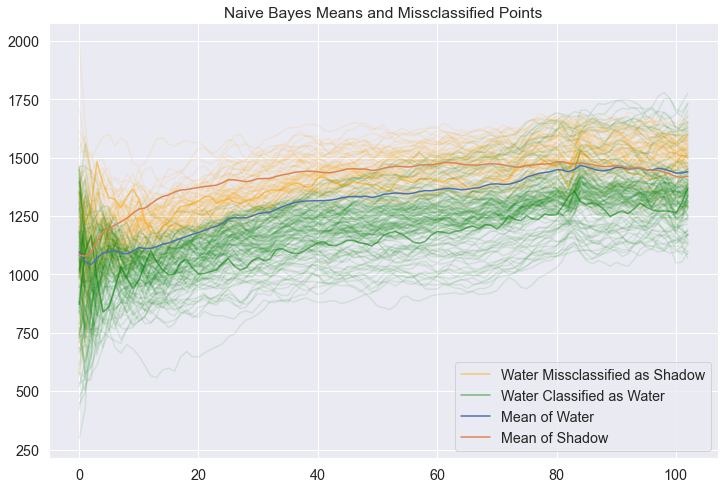

In [135]:
fig, axs = plt.subplots(figsize=(12,8))
plt.plot(X_test[np.where((y_test==1) & (gnb_predictions==7))].T, color='orange', alpha=0.1)
plt.plot(X_test[np.where((y_test==1) & (gnb_predictions==7))][0], color='orange', alpha=0.5,label='Water Missclassified as Shadow')
plt.plot(X_test[np.where((y_test==1) & (gnb_predictions==1))].T, color='green', alpha=0.1)
plt.plot(X_test[np.where((y_test==1) & (gnb_predictions==1))][0], color='green', alpha=0.5, label='Water Classified as Water')
plt.plot(gnb.theta_[0], label='Mean of Water')
plt.plot(gnb.theta_[6], label='Mean of Shadow')
plt.legend()
plt.title('Naive Bayes Means and Missclassified Points')
plt.show()

### Minimum Euclidean Distance Classifier

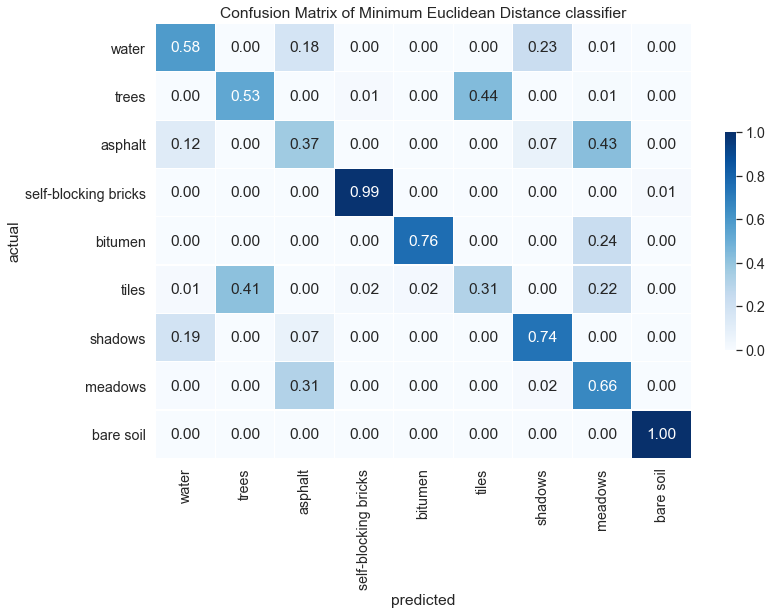

accuracy: 0.5578422201434362
f1 score: 0.5516232727296753


In [136]:
med_conf = confusion_matrix(y_test, med_predictions, normalize='true')
plot_confusion_matrix(med_conf, 'Minimum Euclidean Distance')
print('accuracy:', accuracy_score(y_test, med_predictions))
print('f1 score:', f1_score(y_test, med_predictions, average='weighted'))

The minimum Euclidean Distance Classifier underperforms. There are high percentages in the off diagonal part of the confusion matrix.

### KNN

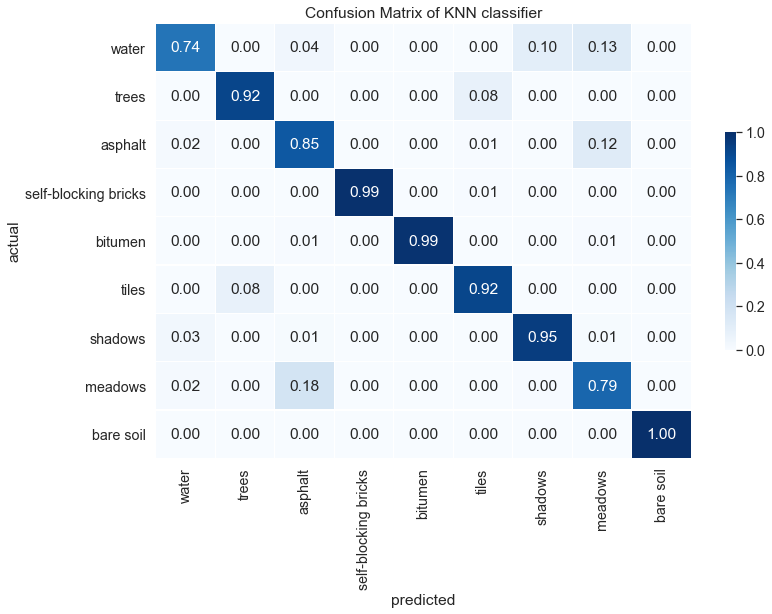

accuracy: 0.8883691923916432
f1 score: 0.8883035917134731


In [137]:
knn_conf = confusion_matrix(y_test, knnc_predictions, normalize='true')
plot_confusion_matrix(knn_conf, 'KNN')
print('accuracy:', accuracy_score(y_test, knnc_predictions))
print('f1 score:', f1_score(y_test, knnc_predictions, average='weighted'))

The KNN classifier achieves a good enough accuracy with high elements on the diagonal. There is sligh drop regarding the `water` endmember which it confuses with shadow and meadows mostly.

### Bayesian Classifier

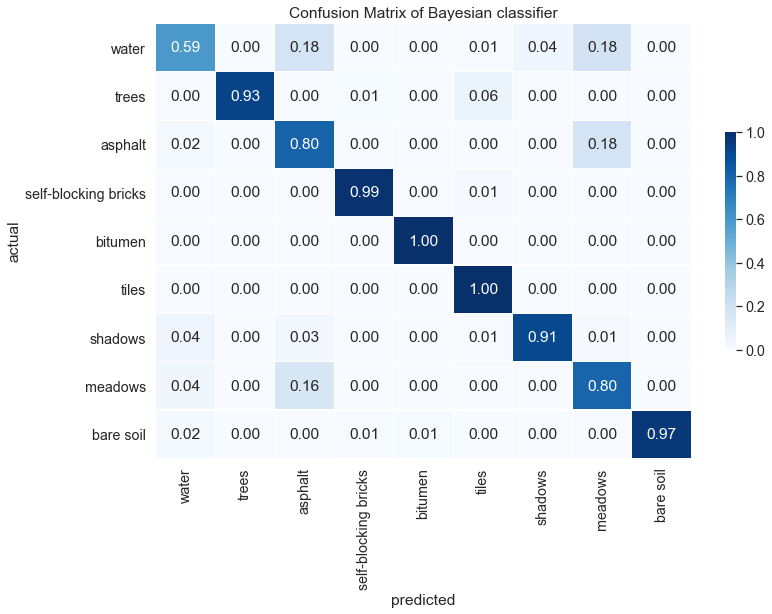

accuracy: 0.8843155597131276
f1 score: 0.8837944245196875


In [138]:
bc_conf = confusion_matrix(y_test, bc_predictions, normalize='true')
plot_confusion_matrix(bc_conf, 'Bayesian')
print('accuracy:', accuracy_score(y_test, bc_predictions))
print('f1 score:', f1_score(y_test, bc_predictions, average='weighted'))

The Bayesian classifier performs good as well. There are three major flaws:
* Water is missclassifed as asphalt and meadows (18% and 18% classification error respectively)
* Asphalt is missiclassied as meadows (18%)
* Meadows is missiclassied as ashpalt (18%)

## B. Comparing the Classifiers

In order to be able to quickly spot any weaknesses of our classifiers, we can plot a combined confusion matrix. The matrix is normalized under the prism of recall.

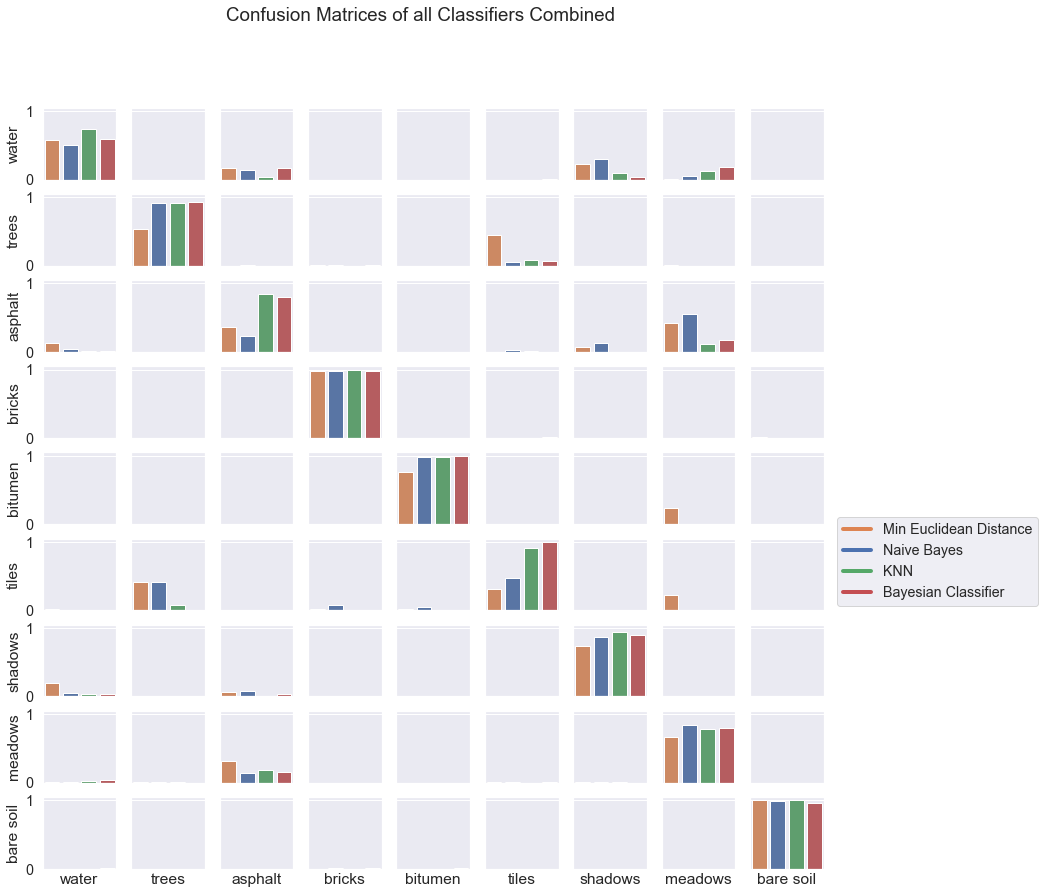

In [245]:
from matplotlib.lines import Line2D

def confusion_to_df(confusion_matrix,classifier):
    df = pd.DataFrame(confusion_matrix)
    df.index.name = 'actual'
    df = df.reset_index()
    df = pd.melt(df,id_vars='actual', var_name='predicted',value_name='class_rate')
    df['classifier'] = classifier
    return df

lmed = confusion_to_df(med_conf,'min_eucl_dist')
lnb = confusion_to_df(gnb_conf,'naive_bayes')
lknn = confusion_to_df(knn_conf, 'knn')
lbc = confusion_to_df(bc_conf, 'bayes_classifier')
lconf = pd.concat([lmed,lnb,lknn,lbc])

fig, axs = plt.subplots(9,9, figsize = (14,14),sharey=True, sharex=True)
palette = [sns.color_palette()[1], sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[3]]

for i in range(9):
    for j in range(9):
        temp = lconf[(lconf.actual==i) & (lconf.predicted==j)]
        sns.barplot(temp.classifier, temp.class_rate,ax=axs[i][j], palette=palette,)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')
        if j == 0:
            axs[i][j].set_ylabel(label_descriptions.iloc[i,1])
        if i== 8:
            axs[i][j].set_xlabel(label_descriptions.iloc[j,1])
            
        axs[i][j].tick_params(labelbottom=False)
plt.suptitle('Confusion Matrices of all Classifiers Combined')
legend_elements = [Line2D([0], [0], color=palette[0], lw=4, label='Min Euclidean Distance')
                   ,Line2D([0], [0], color=palette[1], lw=4, label='Naive Bayes')
                   ,Line2D([0], [0], color=palette[2], lw=4, label='KNN')
                   ,Line2D([0], [0], color=palette[3], lw=4, label='Bayesian Classifier')]
plt.legend(handles=legend_elements,bbox_to_anchor=(4, 5))
plt.show()

Observations:
* All classifiers seem to have trouble identifying water. They mostly missclassify it as asphalt, shadows or meadows
* The `Min Euclidean Distance Classifier` has some trouble identifying trees which it confuses with tiles. The same issue appears for the rest of the classifiers as well, but not in the same degree
* Asphalt is not classified correctly by `Naive Bayes` and `Min Euclidean Distance` as it is getting missclassified as meadows or water (much less though). This is also the case for the rest of the classifiers but not to the same extent.
* Bricks are correctly classified by all of our classifiers
* Bitumen is mostly correctly classified, except of some missclassifications carried out by `Min Euclidean Distance`
* Tiles are missclassified by `Min Euclidean Distance` and `Naive Bayes`. The `Bayesian Classifier` as well as `KNN` do not seem to have any issues classifying them correctly.
* Shadows are mostly correctly classified by all of our classifiers
* There is a pattern with meadows, which are missclassified as asphalt, by all of our classifiers
* Bare soil is correclty classified by all of our classifiers
* In general we did not notice individual weaknesses of different classifiers. Whenever there is an issue of misclassification, it impacts systematically all of our classifiers and the misclassifications occur for the same category, just to a different degree. This might reveal some further issues when it comes to labeling or acquiring the spectral signature of the specific pixels. Since all of our classifiers fail to classify this label, it might be an issue of data quality.

Next we can compare the `f1 score`, which combines the precision and recall of each classifier. It is calculates as the weighted average of the `f1 score` of each class

In [247]:
print('f1 score Naive Bayes:', f1_score(y_test, gnb_predictions, average='weighted'))
print('f1 score Minimum Euclidean Distance:', f1_score(y_test, med_predictions, average='weighted'))
print('f1 score KNN:', f1_score(y_test, knnc_predictions, average='weighted'))
print('f1 score Bayesian Classifier:', f1_score(y_test, bc_predictions, average='weighted'))

f1 score Naive Bayes: 0.6387252125125221
f1 score Minimum Euclidean Distance: 0.5516232727296753
f1 score KNN: 0.8883035917134731
f1 score Bayesian Classifier: 0.8837944245196875


We almost have a tie between the `Bayesian Classifier` and the `KNN` classifier. The next step would be to plot something similar to the ambundance maps for the 4 classifiers. 

In [248]:
def classification_map(class_):
    fig, axs = plt.subplots(1,5,figsize=(20,12))
    axs = axs.ravel()
    predictions = [
        gnb_predictions
        ,med_predictions
        ,knnc_predictions
        ,bc_predictions]
    titles = ['Naive Bayes', 'Min Euclidean Distance', 'KNN', 'Bayesian Classifier']

    axs[0].imshow(Test_Set==class_,cmap='binary')
    axs[0].grid(False)
    axs[0].title.set_text('Ground Truth')
    for i in range(0,4):
        map_ = np.zeros(HSI.shape[:2])
        map_[np.where(Test_Set!=0)] = predictions[i]
        axs[i+1].imshow(map_==class_, cmap='binary')
        axs[i+1].grid(False)
        axs[i+1].title.set_text(titles[i])
    plt.show()

## 1.Water

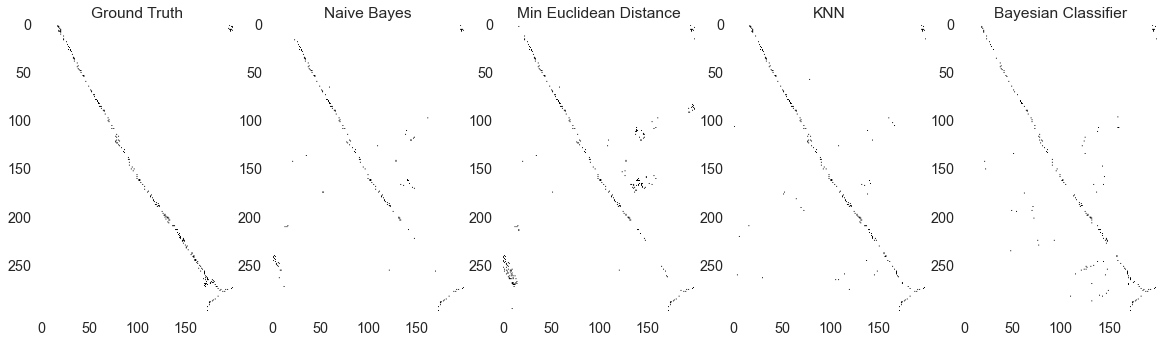

In [249]:
classification_map(1)

All classifiers identify water with with lots of additional noise. This was also visible from the confusion matrices of the classifiers. The `KNN` and the `Bayesian Classifier` perform slightly better though.

## 2.Trees

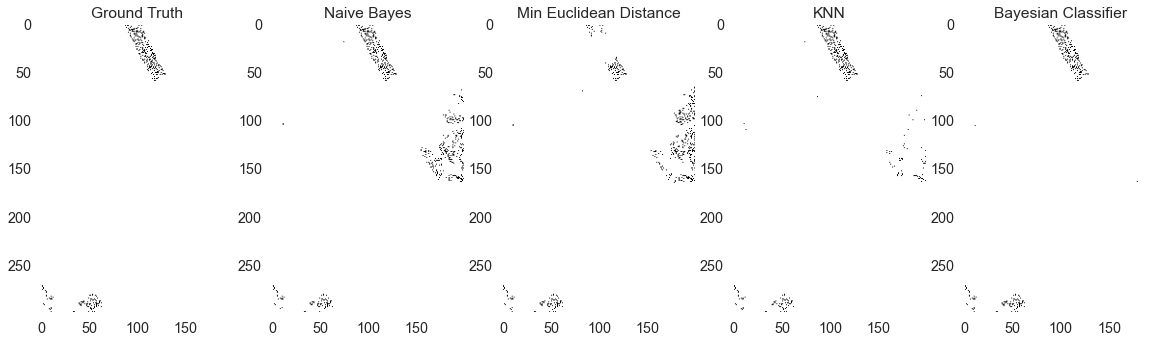

In [250]:
classification_map(2)

`KNN` and the `Bayesian Classifier` achieve the best performance

## 3.Asphalt

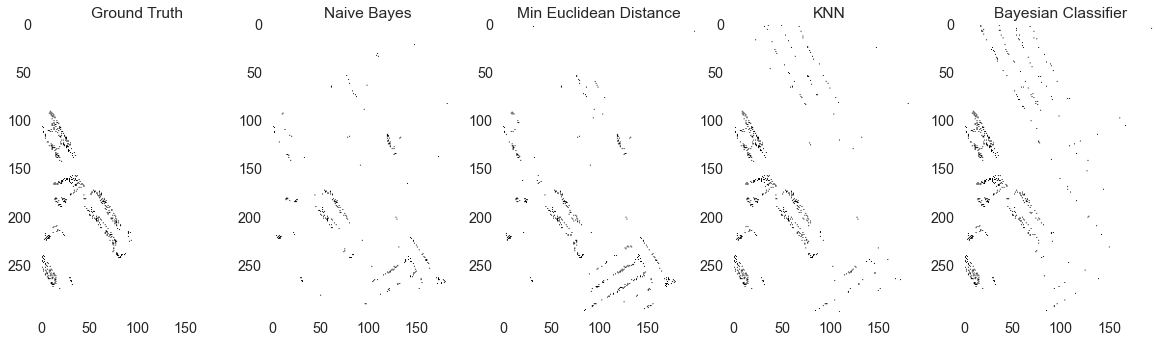

In [251]:
classification_map(3)

Here the `Bayesian Classifier` as well as `KNN` are able to identify asphalt with lots of additional noise

## 4.Self Blocking Bricks

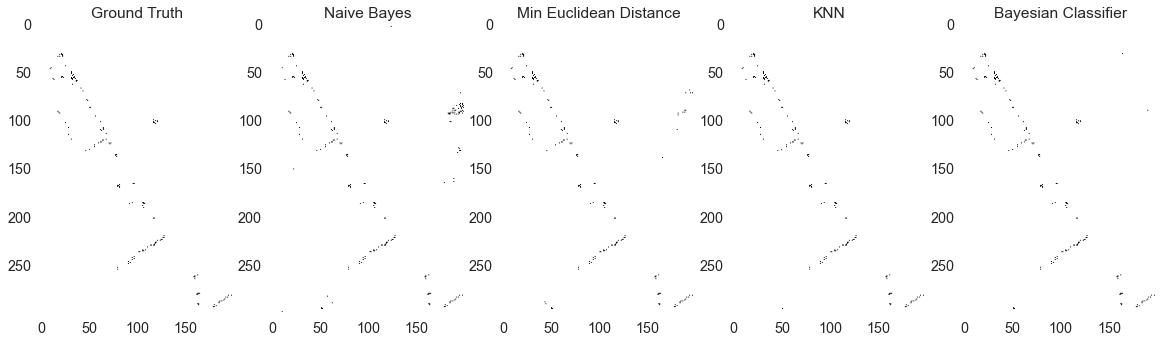

In [252]:
classification_map(4)

Bricks are robustly identified by all classifiers

## 5.Bitumen

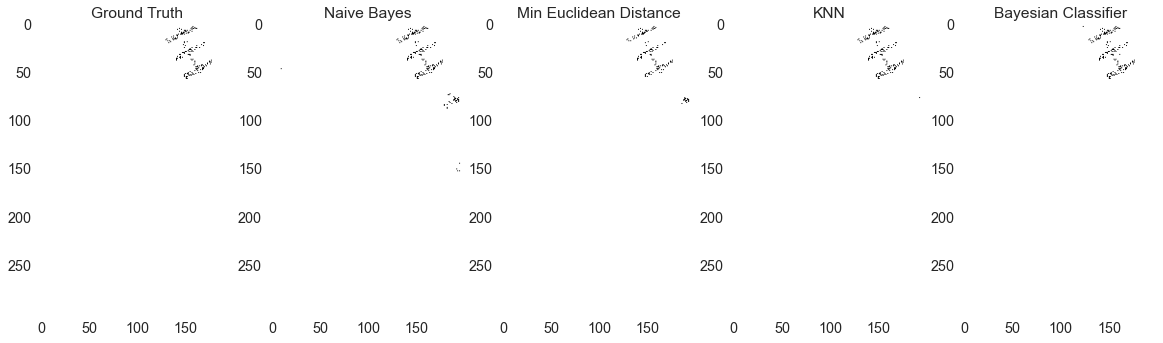

In [253]:
classification_map(5)

## 6.Tiles

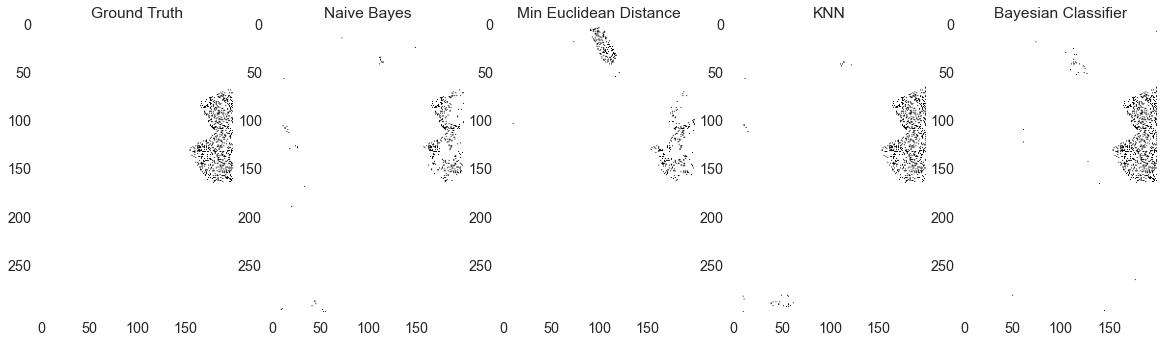

In [254]:
classification_map(6)

Here the `KNN` and the `Bayesian Classifier` achieve the best results

## 7.Shadows

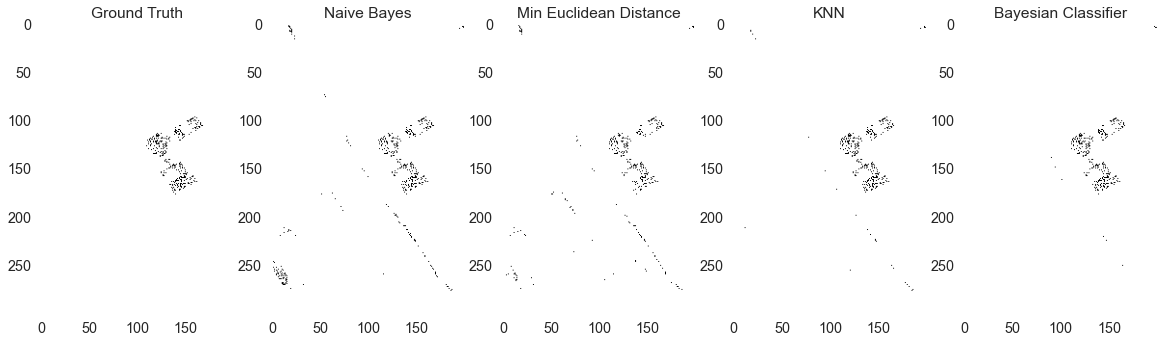

In [255]:
classification_map(7)

## 8.Meadows

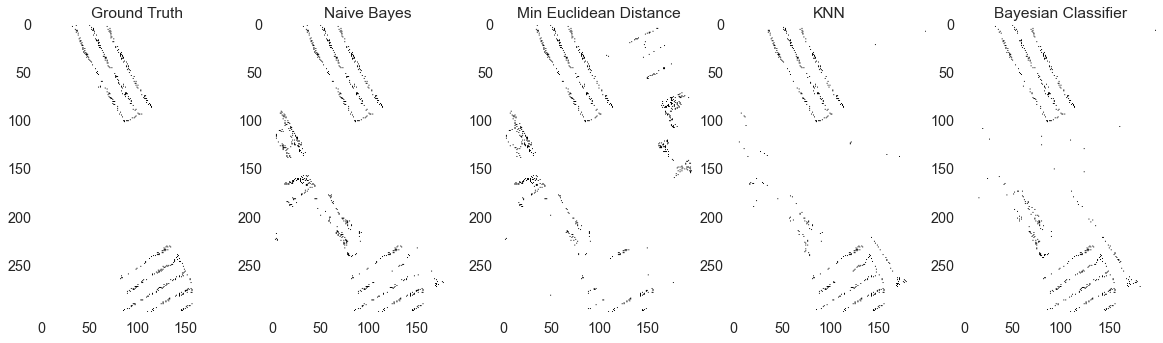

In [256]:
classification_map(8)

## 9.Bare Soil

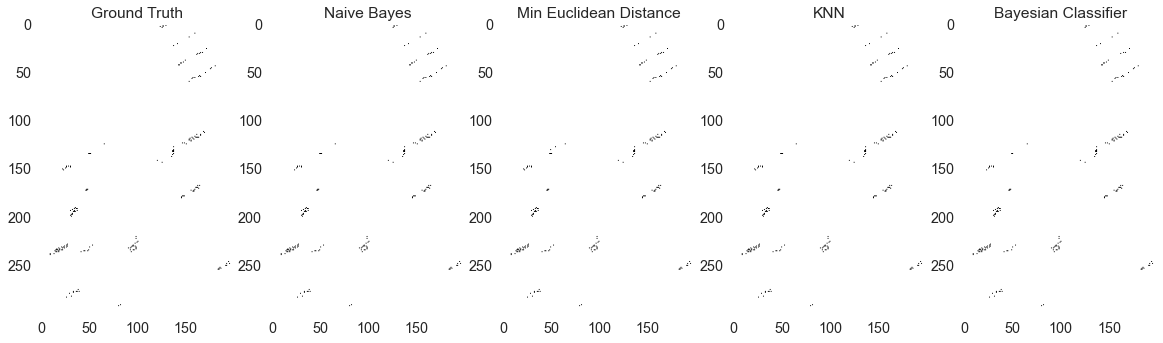

In [257]:
classification_map(9)

Overall, the `Bayesian classifier` as well as the `KNN` classifier have managed to indentify the endmembers with an acceptable performance.  `Naive Bayes` and `Minimum Euclidean Distance` did not manage to perform equally well 

# Part 3. Combining the results

### Ability to discriminate water
In both the spectral unmixing part, as well as the classification part, the models were not able to discriminate water. The Success Rate of the classifers were around 60% and the some of the ambundance maps unmixed water but with lots of additional noise.  

### Trees or Tiles, Tiles or Trees
Looking back at the ambundance maps, we can see that even though trees are correctly unmixed, there is lots of noise coming from tiles as well. This is common for all the linear models used. Someting similar is also observed from the combinded confusion matrix, as well as the classification maps. 

The opposite issue, having Tiles as the ground truth is also present. We observed some missclassifications of the `Naive Bayes` and the `Minimum Euclidean Distance` classifiers. Additionally, spectral unmixing was not very robust for this category. It seems that a `Bayesian Classifier` achieved the best results from all of our approaches.

This systematic "failure" could raise some issues regarding the ability in general to discriminate between trees and tiles 

### Asphalt and Meadows
This is another common issue between the linear models as well as the classifiers. We do observe the inability of both approaches to discriminate asphalt as there is additional noise coming from Meadows.

From the opposite direction, having Meadows are the ground truth, we observe the same results. There is lots of noise, in both spectral unmixing and classification introduced by asphalt.

### Bricks, Bitumen and Bare Soil
For those three endmembers, both approaches achieved high discrimination power. 

### Shadows discriminated well
Shadows were able to be unmixed by the fully contrained liner model and classified properly from most of our classifiers

### Top performers
From this analysis, when it comes to spectral unmixing, the best model was the `Least Squares` model subject to $\sum \theta = 1, \ \ \theta > 0$. Even though it had the largest reconstruction error (which is natural due to its constrains) it was able to unmix the endmembers properly. Regarding the classification, there is a tie between the `KNN` and the fully parametric `Bayesian Classifier`. Personally, I would choose the `Bayesian Classifier` since it requires much less resources for training and predicting, considering always the size of the dataset (usually a pixel contains enough datapoints for calculating the covariances of the different classes)